## Noisy RGB pixels, Conv + UNet + Residual + Conv + Residual + Normalize, 1/8 U-Net bottleneck, L1/L2 + Perceptual + Adversarial Loss + Color Correction Loss

Same as version 1, normalize channels by mean and std after denoising to fix input mean and std.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

# _ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

torch.Size([8, 3, 256, 256])


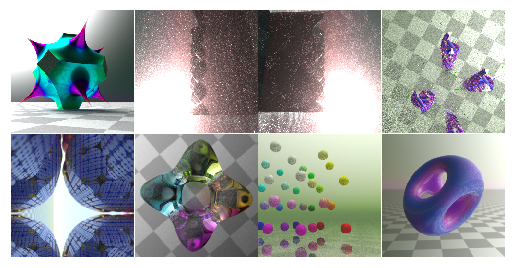

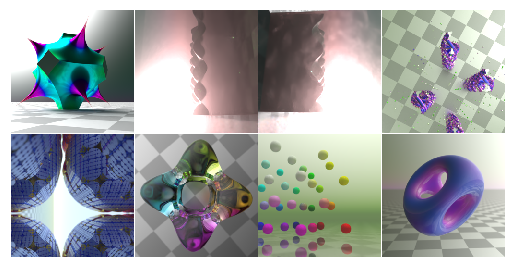

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return self.n

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def compute_W_and_B(batch1, batch2):
    # Reshape batches to (batch_size, num_channels, num_pixels)
    batch1 = batch1.view(batch1.size(0), batch1.size(1), -1)
    batch2 = batch2.view(batch2.size(0), batch2.size(1), -1)
    
    # Compute means of the batches
    mean_batch1 = torch.mean(batch1, dim=2, keepdim=True)
    mean_batch2 = torch.mean(batch2, dim=2, keepdim=True)
    
    # Compute centered batches
    centered_batch1 = batch1 - mean_batch1
    centered_batch2 = batch2 - mean_batch2
    
    # Compute covariance matrix
    xTy = torch.matmul(centered_batch1, centered_batch2.transpose(1, 2))
    xTx = torch.matmul(centered_batch1, centered_batch1.transpose(1, 2))
    
    # Compute weight matrix
    W = torch.matmul(torch.linalg.inv(xTx), xTy)
    W = W.transpose(1, 2)

    # Compute bias vector
    B = mean_batch2.squeeze() - torch.matmul(W, mean_batch1).squeeze()

    return W, B


def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self, normalize):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)
        self.normalize = normalize

    def forward(self, xi):
        ci = self.convi(xi)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        xo = self.convo(ci+do)+xi
        # normalize
        if self.normalize:
            W, B = compute_W_and_B(xo, xi)
            sp = (xo.shape[0], xo.shape[1])
            xo = torch.matmul(W, xo.reshape(*sp, -1)).view_as(xo) + B.reshape(*sp, 1, 1)
        return xo


model = Model(True).to(device)
x = torch.randn((8, 3, 256, 256), device=device)
with torch.no_grad():
    y = model(x)
print(y.shape)

model = Model(False).to(device)
print(model)

torch.Size([8, 3, 256, 256])
Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        csw = 29  # some non power of 2 to break tiles
        generated_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, csw)
        target_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, csw)
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = 0.002)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=10, min_lr=0.00005)
scheduler_d = lr_scheduler.ReduceLROnPlateau(
    optimizer_d, mode='min', factor=0.3, patience=10, min_lr=0.0001)

# model 0: (0.5, 1.0, 1.0, 0.3), lr=(0.002,0.002), f=0.3, mlr=(0.00005,0.0001)
lossfun = CombinedLoss(0.5, 1.0, 1.0, 0.3, device)

Ready
1 g 3.944292056560516 2.808124452829361 d 1.4410023182630536 1.4375958740711212
2 g 2.1858689337968826 2.291664645075798 d 1.4356546372175218 1.43280491232872
3 g 2.0469621807336806 2.132092848420143 d 1.4308139264583588 1.4282164424657822
4 g 1.7755679219961165 2.0467804968357086 d 1.4269661664962765 1.4244672507047653
5 g 1.7361535251140596 1.9478419423103333 d 1.4229353606700896 1.4207261353731155
6 g 1.6674888581037521 1.87715345621109 d 1.419688829779625 1.418303981423378
7 g 1.6963095843791967 1.8593499958515167 d 1.4166442900896072 1.4152700901031494
8 g 1.6731282681226727 1.7683717757463455 d 1.4139924168586733 1.4131856262683868
9 g 1.649272507429123 1.7549199163913727 d 1.4122018754482268 1.4114042669534683
10 g 1.5479731470346452 1.677876740694046 d 1.4103051602840422 1.4092475175857544
11 g 1.5203309655189514 1.6710259169340134 d 1.4082353174686435 1.4074023514986038
12 g 1.4413082450628283 1.6712315827608109 d 1.4064572602510461 1.4054313898086548
13 g 1.496859994530

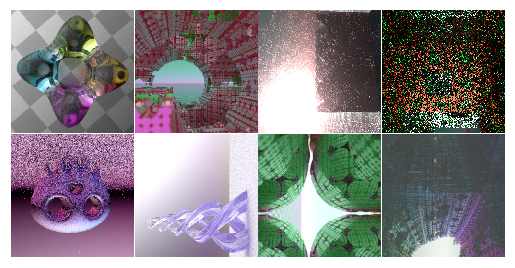

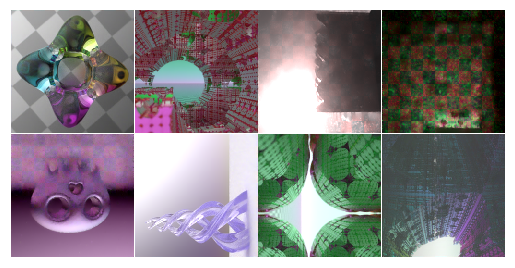

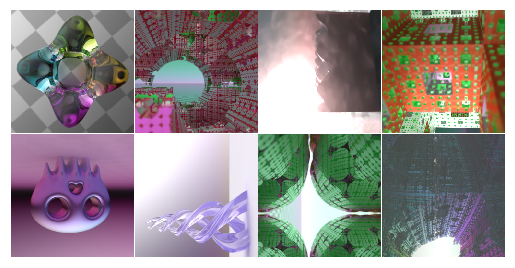

33 g 1.3189886160194875 1.5045391470193863 d 1.3892473012208943 1.3887950032949448 lr 0.002 0.002
34 g 1.183720660209656 1.4979646652936935 d 1.3891622126102445 1.3889125734567642 lr 0.002 0.002
35 g 1.2857239082455632 1.6206686943769455 d 1.3886160016059876 1.388518363237381 lr 0.002 0.002
36 g 1.2298897631466388 1.49908597022295 d 1.3885894775390626 1.388605460524559 lr 0.002 0.002
37 g 1.3418883003294468 1.4882861524820328 d 1.388342013955116 1.3880605101585388 lr 0.002 0.002
38 g 1.275580294430256 1.47742161154747 d 1.385856735706329 1.3846818059682846 lr 0.002 0.002
39 g 1.296209247410297 1.4644730389118195 d 1.3825419098138811 1.3627065271139145 lr 0.002 0.002
40 g 1.2956534355878833 1.4788844585418701 d 1.3911155998706815 1.3927034735679626 lr 0.002 0.002
41 g 1.1776142269372942 1.4533322378993034 d 1.390275695919991 1.3909641653299332 lr 0.002 0.002
42 g 1.2837192937731743 1.4715316444635391 d 1.3874311357736586 1.3893046230077744 lr 0.002 0.002
43 g 1.1865439236164093 1.428445

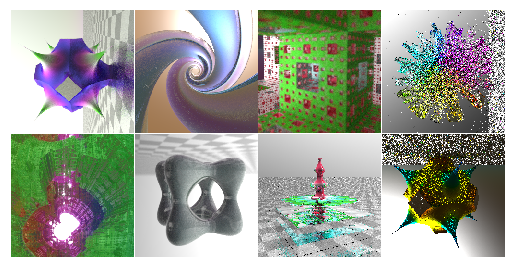

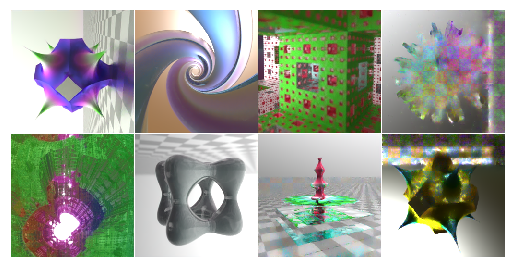

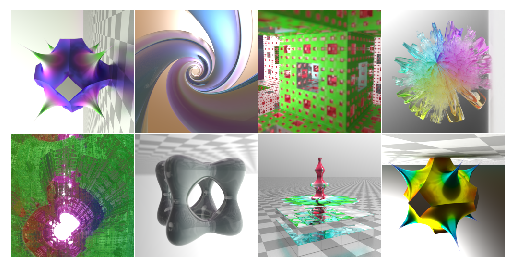

65 g 1.1057236261665824 1.3514041900634766 d 1.1725218176841739 1.1719147711992264 lr 0.002 0.002
66 g 1.1943509101867673 1.3525935262441635 d 1.2482401818037037 1.3905444145202637 lr 0.002 0.002
67 g 1.083957915753126 1.3752893283963203 d 1.3887163639068603 1.388430967926979 lr 0.002 0.002
68 g 1.1278951801359653 1.3560186624526978 d 1.3890907347202301 1.3885969370603561 lr 0.002 0.002
69 g 1.1096127517521381 1.359486572444439 d 1.3882431179285049 1.3885299861431122 lr 0.002 0.002
70 g 1.079327338933945 1.3542223125696182 d 1.3881230890750889 1.388275384902954 lr 0.002 0.002
71 g 1.1236337214708327 1.3570229932665825 d 1.3877916038036346 1.388056680560112 lr 0.002 0.002
72 g 1.0385214164853096 1.3523403480648994 d 1.3880721896886823 1.3880805969238281 lr 0.002 0.002
73 g 1.0217888623476026 1.3318531140685081 d 1.3883496403694153 1.3888554126024246 lr 0.002 0.002
74 g 1.0400143884122373 1.3349460810422897 d 1.387979444861412 1.388254389166832 lr 0.002 0.002
75 g 1.0735414259135723 1.38

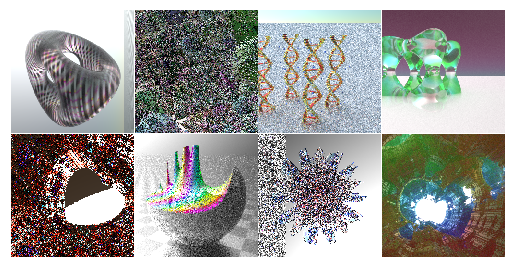

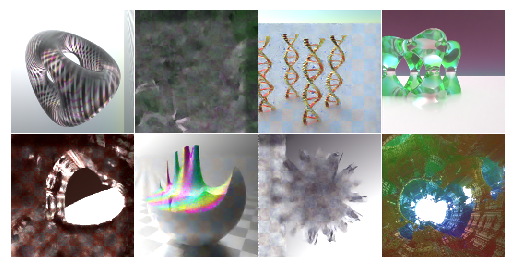

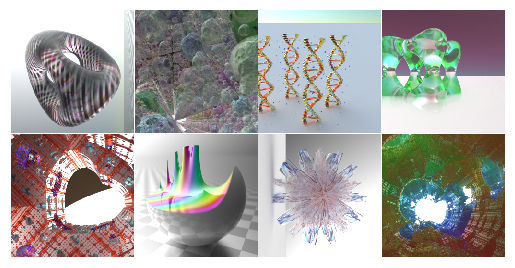

97 g 1.0657310009002685 1.3020872101187706 d 1.3858490854501726 1.3816780894994736 lr 0.002 0.00017999999999999998
98 g 1.0512207925319668 1.3009453788399696 d 1.3823241621255875 1.381074607372284 lr 0.002 0.0001
99 g 1.0260935977101326 1.304857812821865 d 1.382249569892883 1.3802045732736588 lr 0.002 0.0001
100 g 0.9629777424037457 1.3012081906199455 d 1.3810459405183795 1.3789257407188416 lr 0.002 0.0001
101 g 1.0962672248482703 1.3103107511997223 d 1.3739597380161284 1.3768783509731293 lr 0.002 0.0001
102 g 1.0157578840851786 1.2951830178499222 d 1.3832748383283617 1.378120869398117 lr 0.002 0.0001
103 g 1.0645995795726777 1.394888013601303 d 1.3762404918670657 1.3759336471557617 lr 0.002 0.0001
104 g 1.129484492540359 1.3085529953241348 d 1.3732082515954969 1.367292270064354 lr 0.002 0.0001
105 g 0.9906841583549978 1.365094155073166 d 1.3550371438264845 1.3316215574741364 lr 0.002 0.0001
106 g 1.0967686936259269 1.3236469104886055 d 1.298087227344513 1.284030720591545 lr 0.002 0.00

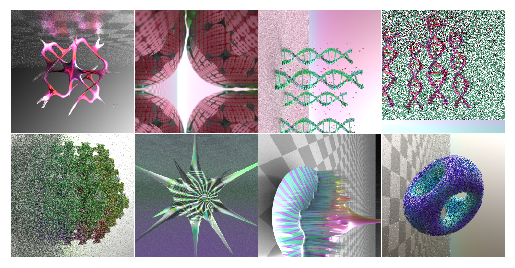

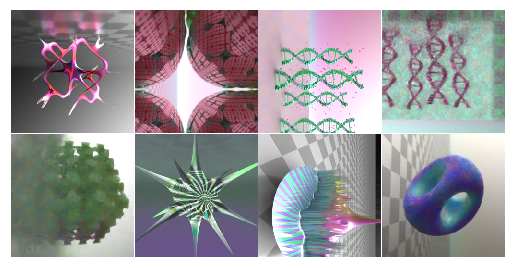

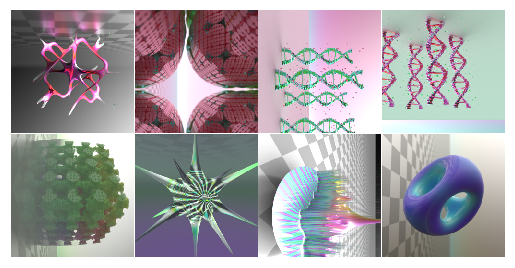

129 g 1.0558320239186285 1.2617023959755898 d 1.1905094802379612 1.1894191354513168 lr 0.0006 0.0001
130 g 1.1495178282260894 1.2591595724225044 d 1.1908334136009218 1.188456505537033 lr 0.0006 0.0001
131 g 0.998953440785408 1.2656701058149338 d 1.1890183746814724 1.1878982782363892 lr 0.0006 0.0001
132 g 0.9932467371225355 1.26442239433527 d 1.187789046764374 1.186974212527275 lr 0.0006 0.0001
133 g 1.0593496255576609 1.2675059214234352 d 1.187232622504234 1.1860053986310959 lr 0.0006 0.0001
134 g 0.992891576886177 1.258584052324295 d 1.1868550330400462 1.185282438993454 lr 0.0006 0.0001
135 g 1.0044289216399191 1.2649894878268242 d 1.1860114723443986 1.1847505867481232 lr 0.0006 0.0001
136 g 1.0261218711733817 1.2606397718191147 d 1.186292558908463 1.1843115985393524 lr 0.0006 0.0001
137 g 0.9068016067147255 1.258525773882866 d 1.183841496706009 1.1835504323244095 lr 0.0006 0.0001
138 g 1.0763527512550355 1.258891984820366 d 1.1841296315193173 1.1829562485218048 lr 0.0006 0.0001
139 

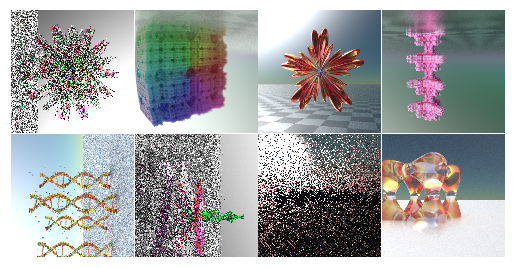

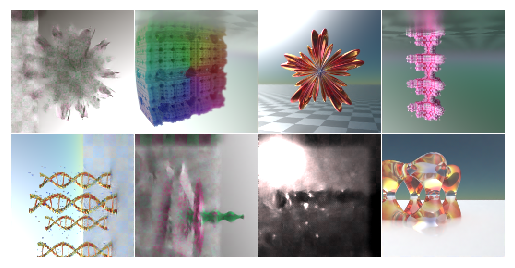

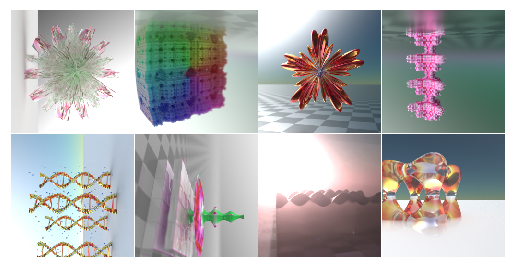

161 g 1.0690266005694864 1.2541953697800636 d 1.1734817951917647 1.1729809939861298 lr 0.0006 0.0001
162 g 0.9969471395015717 1.2490451484918594 d 1.1731157749891281 1.1726831942796707 lr 0.0006 0.0001
163 g 1.0277239978313446 1.256519578397274 d 1.1725448071956635 1.1721207946538925 lr 0.0006 0.0001
164 g 1.0067431554198265 1.2510165199637413 d 1.1730068832635878 1.1716825813055038 lr 0.0006 0.0001
165 g 0.9809350028634074 1.2482882514595985 d 1.1724448800086977 1.1712338030338287 lr 0.0006 0.0001
166 g 1.0266508311033247 1.2481052726507187 d 1.1715009182691576 1.170859456062317 lr 0.0006 0.0001
167 g 1.064213126897812 1.251956395804882 d 1.1723399847745897 1.170788124203682 lr 0.0006 0.0001
168 g 1.0460640862584114 1.2515347972512245 d 1.1705030232667921 1.170346200466156 lr 0.0006 0.0001
169 g 1.081023436784744 1.251439481973648 d 1.170527985692024 1.1701347082853317 lr 0.0006 0.0001
170 g 1.009619078040123 1.253610610961914 d 1.1692942380905147 1.1695802360773087 lr 0.0006 0.0001
1

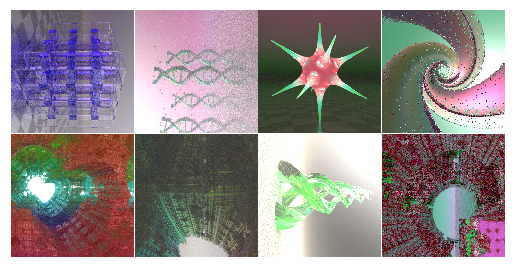

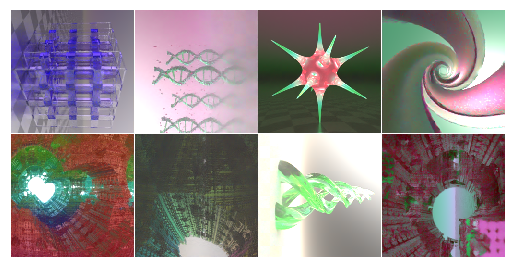

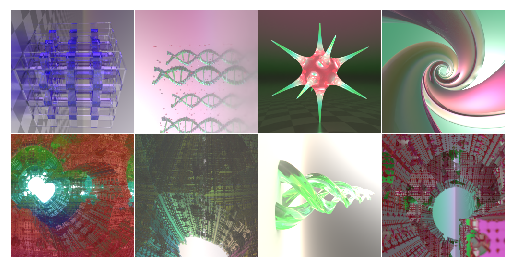

193 g 0.9799133718013762 1.2462461292743683 d 1.164142796397209 1.163650169968605 lr 0.0006 0.0001
194 g 0.9621678918600082 1.2477887198328972 d 1.1642768025398256 1.1636346131563187 lr 0.0006 0.0001
195 g 0.8444798499345777 1.2472001761198044 d 1.1639297723770143 1.1634412109851837 lr 0.00017999999999999998 0.0001
196 g 0.9286805063486099 1.2353256717324257 d 1.1639064580202103 1.1633041501045227 lr 0.00017999999999999998 0.0001
197 g 0.9713485956192016 1.2350005805492401 d 1.1636425405740736 1.1631543934345245 lr 0.00017999999999999998 0.0001
198 g 1.072003574669361 1.234268769621849 d 1.1635142654180528 1.1631841957569122 lr 0.00017999999999999998 0.0001
199 g 0.9696327008306979 1.2336093932390213 d 1.1641028970479965 1.1631088554859161 lr 0.00017999999999999998 0.0001
200 g 1.0138281412422656 1.242035150527954 d 1.1630127370357515 1.162903517484665 lr 0.00017999999999999998 0.0001
201 g 0.9689058691263199 1.2362267673015594 d 1.16312030851841 1.1627812683582306 lr 0.000179999999999

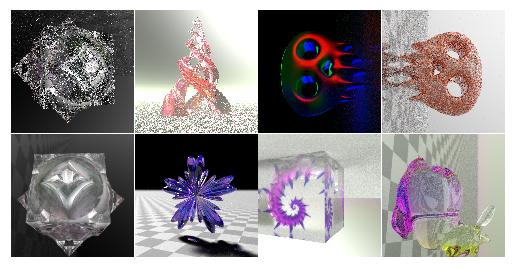

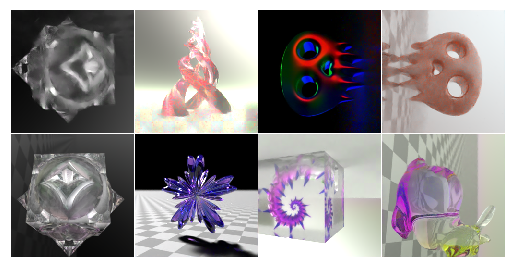

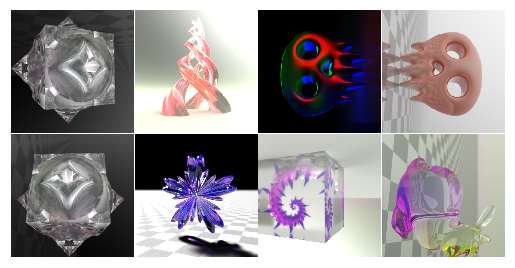

225 g 1.0638689376413824 1.2290934547781944 d 1.1598291158676148 1.1592523008584976 lr 0.00017999999999999998 0.0001
226 g 0.772187753021717 1.2316231057047844 d 1.1597088575363161 1.1588610112667084 lr 0.00017999999999999998 0.0001
227 g 1.0127968579530717 1.2316490933299065 d 1.1595571994781493 1.1588040441274643 lr 0.00017999999999999998 0.0001
228 g 0.9739382028579714 1.2306913882493973 d 1.1595048069953917 1.1588342487812042 lr 0.00017999999999999998 0.0001
229 g 1.0003322899341585 1.228670485317707 d 1.1591550916433335 1.1587151139974594 lr 0.00017999999999999998 0.0001
230 g 1.037290555983782 1.231613539159298 d 1.1595212996006012 1.1584948599338531 lr 0.00017999999999999998 0.0001
231 g 0.9863097451627255 1.2328213155269623 d 1.1590004771947862 1.1584111899137497 lr 0.00017999999999999998 0.0001
232 g 1.0738797292113305 1.2333272770047188 d 1.1585370838642117 1.1581135839223862 lr 0.00017999999999999998 0.0001
233 g 1.0178776010870934 1.2291548401117325 d 1.1585824579000472 1.1

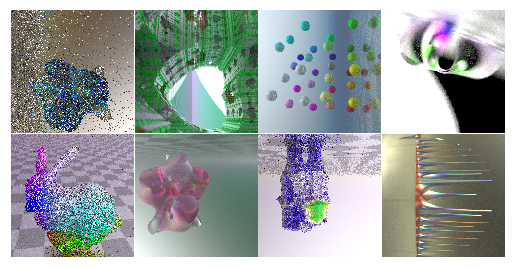

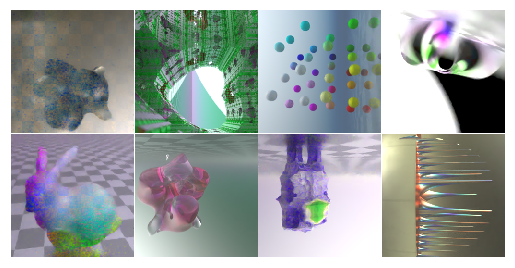

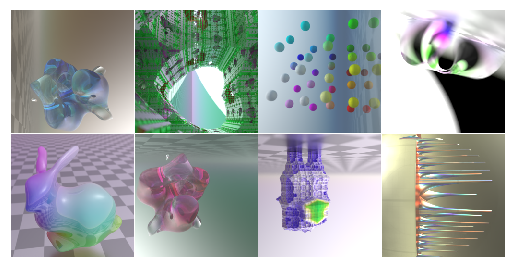

257 g 0.9293185740709305 1.2279702350497246 d 1.1560561448335653 1.1555048674345016 lr 5.399999999999999e-05 0.0001
258 g 0.9781172305345536 1.2260350361466408 d 1.156036549806595 1.1554789394140244 lr 5.399999999999999e-05 0.0001
259 g 1.0135511085391042 1.2262290716171265 d 1.155677503347397 1.1554033756256104 lr 5.399999999999999e-05 0.0001
260 g 1.0770643673837184 1.227643832564354 d 1.1557902216911318 1.155221551656723 lr 5.399999999999999e-05 0.0001
Done


In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 24  # how much RAM do I have?
batch_per_epoch = 40
batch_per_epoch_val = 8

num_epoch = 1024

dataset = RawDataset(batch_size*batch_per_epoch)

valloader = []
for x, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
    valloader.append((x, y))
    if len(valloader) >= batch_per_epoch_val:
        break

print("Ready")

for epoch in range(num_epoch):
    if epoch == 16:
        model.normalize = True
        from collections import defaultdict
        optimizer.__setstate__({'state': defaultdict(dict)})
        optimizer_d.__setstate__({'state': defaultdict(dict)})
        print("Set model normalize to True")

    # training
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    mean_loss_g, mean_loss_d = 0.0, 0.0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
    
    # validation
    mean_loss_gv, mean_loss_dv = 0.0, 0.0
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device)
            x = torch.log(1+x)
            y = torch.log(1+y)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_outputs = discriminator(y)
            d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

            fake_images = model(x)
            fake_outputs = discriminator(fake_images)
            d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

            d_loss = d_loss_real + d_loss_fake
            g_loss = lossfun(fake_images, y, fake_outputs)

            mean_loss_gv += g_loss.item() / batch_per_epoch_val
            mean_loss_dv += d_loss.item() / batch_per_epoch_val
    
    # scheduling / verbose
    epoch += 1
    if epoch > 16:
        scheduler.step(mean_loss_gv)
        scheduler_d.step(mean_loss_dv)
        if scheduler.get_last_lr()[0] <= scheduler.min_lrs[0]:
            break
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv} lr {scheduler.get_last_lr()[0]} {scheduler_d.get_last_lr()[0]}")
    else:
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv}")
    torch.save(model, "resunet2gan_3_x.pth")
    torch.save(discriminator, "resunet2gan_3_xd.pth")
    if epoch % 32 == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size=8)
        for x, y in loader:
            with torch.no_grad():
                x1 = torch.log(1+x.to(device))
                y1 = torch.exp(model(x1))-1
            plot_imgs(x)
            plot_imgs(y1)
            plot_imgs(y)
            break

print("Done")